In [5]:
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = 20, 10
import matplotlib.pyplot as plt

In [6]:
from data_preprocsssing import *
from pricing_models import *
from hedging_strategies import *
from volatility_models import WingModel
from utils import pool_init
import numpy as np
import pandas as pd

In [7]:
d_df, d_tkr2info = load_derivatives_df_n_cast()
d_op_df, u_op_df, d_hp_df, u_hp_df, d_lp_df, u_lp_df, d_cp_df, u_cp_df = get_mkt_data_minutes(d_df, freq=15)

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2017 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


In [8]:
d_op_df.head()

,IO2007-C-3400.CFE,IO2007-C-3450.CFE,IO2007-C-3500.CFE,IO2007-C-3550.CFE,IO2007-C-3600.CFE,IO2007-C-3650.CFE,IO2007-C-3700.CFE,IO2007-C-3750.CFE,IO2007-C-3800.CFE,IO2007-C-3850.CFE,...,IO2008-P-4100.CFE,IO2008-P-4150.CFE,IO2008-P-4200.CFE,IO2008-P-4250.CFE,IO2008-P-4300.CFE,IO2008-P-4350.CFE,IO2008-P-4400.CFE,IO2008-P-4450.CFE,IO2008-P-4500.CFE,IO2008-P-4550.CFE
2020-04-21 09:45:00,NaN,NaN,297.0,NaN,227.0,NaN,172.2,NaN,125.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-21 10:00:00,NaN,NaN,NaN,NaN,222.6,NaN,NaN,NaN,118.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-21 10:15:00,NaN,NaN,278.0,NaN,213.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-21 10:30:00,NaN,NaN,NaN,NaN,213.8,NaN,157.0,NaN,112.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-21 10:45:00,NaN,NaN,265.8,NaN,202.0,NaN,153.6,126.0,108.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
u_op_df.head()

,000300.SH
2020-04-21 09:45:00,3838.2314
2020-04-21 10:00:00,3822.0147
2020-04-21 10:15:00,3814.6914
2020-04-21 10:30:00,3813.7967
2020-04-21 10:45:00,3803.7664


In [10]:
assert len(d_op_df) == len(u_op_df)

In [11]:
d_t_df = add_info2p_df(d_op_df)

op_iv_dct = gen_p_iv_gks_dct(d_df["d_code"], d_t_df, u_op_df, d_tkr2info)

C:\Users\hoore\miniconda3\envs\work\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


In [12]:
from tqdm import tqdm

In [13]:
mat_dt_lst = d_df.lst_dt.unique().tolist()

df_lst = []
for mdt in mat_dt_lst:
    op_tkrs = d_df[d_df.lst_dt == pd.to_datetime(mdt)].d_code

    c_mdl = WingModel(2.9, 2.9, vol_ref=0.2)
    p_mdl = WingModel(2.9, 2.9, vol_ref=0.5)
    
    rst_lst = []
    for t in tqdm(range(len(d_op_df))):
        tdf = pd.DataFrame(data=[op_iv_dct[tkr].iloc[t, :] for tkr in op_tkrs], index=op_tkrs).loc[:, ["K", "mkt_iv", "tp"]]
        tdf.sort_values("K", inplace=True)

        cdf = tdf[tdf.tp == "c"].dropna()
        pdf = tdf[tdf.tp == "p"].dropna()

        cdf["pos"] = np.sign(c_mdl.fit(cdf.mkt_iv.values, cdf.K.values).predict(cdf.K.values) - cdf.mkt_iv.values)
        pdf["pos"] = np.sign(p_mdl.fit(pdf.mkt_iv.values, pdf.K.values).predict(pdf.K.values) - pdf.mkt_iv.values)

        tdf["pos"] = cdf["pos"].append(pdf["pos"])
        rst_lst.append(tdf["pos"])
    
    df = pd.concat(rst_lst, axis=1)
    df_lst.append(df)

100%|████████████████████████████████████████████████████████████████████████████████| 672/672 [00:24<00:00, 27.99it/s]


In [14]:
pos_tgt_df = pd.concat(df_lst, axis=0).sort_index()
pos_tgt_df.columns = d_op_df.index

In [15]:
pos_tgt_df.fillna(0, inplace=True)

In [16]:
pw_mat = np.vstack((pos_tgt_df.values, np.zeros((1, len(d_op_df))))).reshape(97, len(d_op_df), 1)

In [17]:
rsk_tgt_mat = np.zeros((d_op_df.shape[0], 1), dtype=float)
w_df, hr_df = calc_hedge_w_n_expo(op_iv_dct, u_op_df, pw_mat, rsk_tgt_mat, (-1,))
pw_pnl_df, hg_pnl_df = calc_portfolio_pnl(w_df, d_op_df, d_hp_df, d_lp_df, d_cp_df, u_op_df, u_cp_df, pw_mat)

In [18]:
(pw_pnl_df > 0).sum() / len(pw_pnl_df)

0.48214285714285715

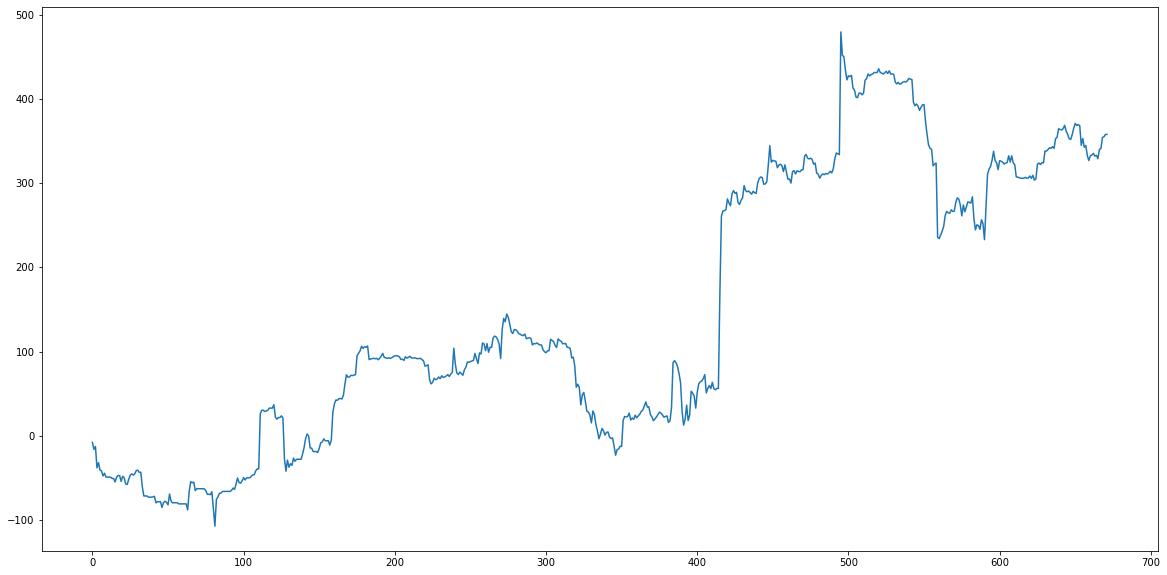

In [19]:
plt.plot(pw_pnl_df.values.cumsum())